# Sequence to Sequence Model with Attention 

This is a sequence to sequence  model with attention. This is just to demonstrate the architecture for performance comparision  you must:
- Get a large training data sets 
- Clean the data set properly to limit the vocabulary size
- Tune the hyper-parameters 


number of data points: 12225
Num encoder token 250
Num decoder tokens 240
Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Encoder-Input-Layer (Input  [(None, None, 250)]          0         []                            
 Layer)                                                                                           
                                                                                                  
 Encoder-LSTM (LSTM)         [(None, None, 300),          661200    ['Encoder-Input-Layer[0][0]'] 
                              (None, 300),                                                        
                              (None, 300)]                                                        
                                                                                                  
 input_14 (InputL

C:\Users\jayanti.prasad\Anaconda3\envs\aiml_env\lib\site-packages\keras\src\optimizers\legacy\adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


153/153 [==============================] - 16s 87ms/step - loss: 1.6024 - accuracy: 0.7071 - val_loss: 1.6268 - val_accuracy: 0.6679
Epoch 2/40
153/153 [==============================] - 14s 89ms/step - loss: 1.3735 - accuracy: 0.4046 - val_loss: 1.5897 - val_accuracy: 0.1266
Epoch 3/40
153/153 [==============================] - 14s 90ms/step - loss: 1.3502 - accuracy: 0.1274 - val_loss: 1.5846 - val_accuracy: 0.1263
Epoch 4/40
153/153 [==============================] - 13s 83ms/step - loss: 1.3409 - accuracy: 0.1284 - val_loss: 1.5750 - val_accuracy: 0.1335
Epoch 5/40
153/153 [==============================] - 13s 85ms/step - loss: 1.3322 - accuracy: 0.1276 - val_loss: 1.5715 - val_accuracy: 0.1249
Epoch 6/40
153/153 [==============================] - 13s 88ms/step - loss: 1.3268 - accuracy: 0.1265 - val_loss: 1.5569 - val_accuracy: 0.1240
Epoch 7/40
153/153 [==============================] - 13s 88ms/step - loss: 1.3204 - accuracy: 0.1282 - val_loss: 1.5606 - val_accuracy: 0.1316
Epo

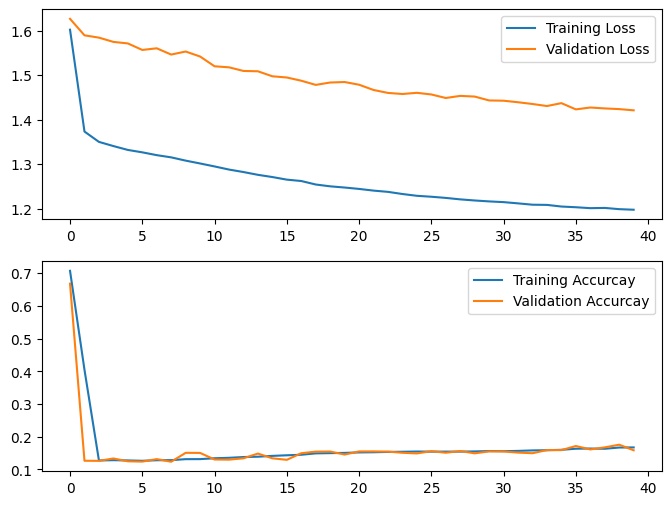

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Attention
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers.legacy import Adam

input_data_path = r"C:\Users\jayanti.prasad\Data\NLP_DATA\seq2seq_data\fra.txt"

def build_vocabulary(input_data, output_data):
     V = []
     for data in [input_data, output_data]:
        tokens = " ".join (data).split(" ")
        vocab = Counter (tokens)
        token_dict = dict (vocab)
        df = pd.DataFrame (columns=['word','count'])
        df ['word'] = list (token_dict.keys())
        df ['count'] = list (token_dict.values())
        df = df.sort_values (by=['count'], ascending=False, ignore_index=True)
        V.append (df)
     return V                          
    

def text2vec (input_text, df_vocab, vocab_size, vec_len):
    D = df_vocab.iloc[:vocab_size]
    ids = [i for i in range (0, len (D))]
    D = D.assign (id=ids)
    D.index = D['word'].to_list()
    text_vecs = []
    for text in input_text:
        words = text.split(" ")
        words = [w for w in words if w in D.index]
        vec = [D.loc[w]['id'] for w in words]
        text_vecs.append (vec[:vec_len])
    return text_vecs     



class LSTM_Attention:
    def __init__(self,workspace_dir,num_encoder_tokens, num_decoder_tokens, latent_dim):

        self.workspace = workspace_dir
        self.model_dir = self.workspace + os.sep + "trained_model"
        self.log_dir = self.workspace + os.sep + "log"
        os.makedirs(self.workspace, exist_ok=True)
        os.makedirs(self.model_dir, exist_ok=True)
        os.makedirs(self.log_dir, exist_ok=True)
        self.num_encoder_tokens = num_encoder_tokens
        self.num_decoder_tokens = num_decoder_tokens
        self.latent_dim = latent_dim 
        self.build_model()

    def build_model (self, ):
        # Define the input sequence
        encoder_inputs = Input(shape=(None, self.num_encoder_tokens),name='Encoder-Input-Layer')
        # LSTM layer
        encoder = LSTM(latent_dim, return_sequences=True, return_state=True,name='Encoder-LSTM')
        encoder_outputs, state_h, state_c = encoder(encoder_inputs)

        # We discard `encoder_outputs` and only keep the states
        encoder_states = [state_h, state_c]

        # Set up the decoder, using `encoder_states` as initial state
        decoder_inputs = Input(shape=(None, self.num_decoder_tokens))

        # We set up our decoder to return full output sequences,
        # and to return internal states as well. We don't use the
        # return states in the training model, but we will use them in inference
        decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,name='Decoder-LSTM')
        decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

        # Attention layer
        attention = Attention(name='Attention-Layer')
        attention_output = attention([encoder_outputs, decoder_outputs])

        # Dense layer
        decoder_dense = Dense(num_decoder_tokens, activation='softmax',name='Decoder-Dense')
        decoder_outputs = decoder_dense(attention_output)

        # Define the model
        self.model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    def fit_model(self, encoder_in_data, decoder_in_data, decoder_target_data, nepochs):

        batch_size = 64 
            
        chkpt = ModelCheckpoint(filepath=self.model_dir + os.sep + "model.hdf5",
             save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True)

        tboard = TensorBoard(log_dir=self.log_dir)
        callbacks = [chkpt, tboard]

        optimizer=Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.001)
        
        # Compiling and training the model
        self.model.compile(optimizer='RMSprop',metrics=['accuracy'],
                     loss='categorical_crossentropy')
        hist = self.model.fit([encoder_in_data, decoder_in_data],
            decoder_target_data, callbacks=callbacks, batch_size=batch_size, epochs=nepochs,
            validation_split=0.2)
 
        return hist


     
if __name__ == "__main__":
    workspace = "tmp"
    max_encoder_vec_len = 8
    max_decoder_vec_len = 8
    latent_dim  = 300
    num_epochs = 40

    with open(input_data_path, 'r', encoding='utf-8') as f:
        lines = f.read().split('\n')

    input_texts = []
    output_texts = []

    for i in range (1, 20000):
        row = lines[i].split('\t')
        if row[0] not in input_texts:
           input_texts.append (row[0])
           output_texts.append ("__START__ " + row[1] + " __STOP__")

    print("number of data points:", len(input_texts))

    [vocab_in, vocab_out ] =  build_vocabulary(input_texts, output_texts)
     
    vocab_in.to_csv(workspace + os.sep + "input_vocab.csv")
    vocab_out.to_csv(workspace + os.sep + "output_vocab.csv")

    vocab_in = vocab_in [vocab_in['count'] > 20]
    vocab_out = vocab_out [vocab_out['count'] > 20]

    num_encoder_tokens = len (vocab_in)
    num_decoder_tokens = len (vocab_out)
    print("Num encoder token",num_encoder_tokens)
    print("Num decoder tokens", num_decoder_tokens)
    

    M = LSTM_Attention (workspace, num_encoder_tokens, num_decoder_tokens, latent_dim) 
    print(M.model.summary()) 

    plot_model (M.model)
    
    
    input_vecs  = text2vec (input_texts, vocab_in,  num_encoder_tokens, max_encoder_vec_len)
    output_vecs = text2vec (output_texts, vocab_out, num_decoder_tokens, max_decoder_vec_len)

    encoder_in_data = np.zeros((len(input_vecs), max_encoder_vec_len, num_encoder_tokens), dtype='float32')
    
    decoder_in_data = np.zeros((len(output_vecs), max_decoder_vec_len, num_decoder_tokens), dtype='float32')
    decoder_target_data = np.zeros((len(output_vecs), max_decoder_vec_len, num_decoder_tokens), dtype='float32')

    for i in range (0, len (input_vecs)):
       if  (len (input_vecs[i]) > 0)  & (len (output_vecs[i]) > 0): 
           for j, token_id in enumerate (input_vecs[i]):
               encoder_in_data[i, j, token_id] = 1
           for j, token_id in enumerate (output_vecs[i][1:]):
               decoder_in_data[i, j, token_id] = 1
           for j, token_id in enumerate (output_vecs[i][:-1]):
               decoder_target_data[i, j, token_id] = 1

   
    # Model Summary
    print(M.model.summary())

    print("encoder_in_data shape:", encoder_in_data.shape)
    print("decoder_in_data shape:", decoder_in_data.shape)
    print("decoder_target_data shape:", decoder_target_data.shape)

    print("num_epcohs")

    hist = M.fit_model(encoder_in_data, decoder_in_data, decoder_target_data,num_epochs)

    fig, axs = plt.subplots(2, 1, figsize=(8, 6))
    axs[0].plot(hist.history['loss'], label='Training Loss')
    axs[0].plot(hist.history['val_loss'], label='Validation Loss')
    axs[0].legend()
    axs[1].plot(hist.history['accuracy'],label='Training Accurcay')
    axs[1].plot(hist.history['val_accuracy'],label='Validation Accurcay')
    axs[1].legend()

    plt.show()
